# Semantic Plagiarism Detection of Bangla: Paraphrase Generation and Sentence Embedding using Language Model


# Abstract
Bangla, the seventh most spoken language in the world, remains underrepresented in the development of advanced NLP tools. Plagiarism detection is especially critical in low-resource languages like Bangla, where traditional plagiarism detection tools often fail to detect complex paraphrasing and semantic similarity. To address this, I have proposed a hybrid approach for semantic plagiarism detection in Bangla by combining paraphrase generation and sentence embedding using Large Language Models (LLMs). Models such as BanglaT5, and multilingual versions of BART are employed for paraphrasing. To measure semantic similarity between original and paraphrased texts, I have used Bangla-BERT. Evaluation metrics including F1-score ans BERTScore are used to assess performance. My findings shows that Bangla-T5 performed good than mBART in different threshold. 



## Research Question
How effective is the combination of mBART-based paraphrase generation and sentence embedding techniques in detecting semantic plagiarism in Bangla text?

# Methodology

In this project for detecting semantic plagiarism using a hybrid approach. The first part involves paraphrasing, and the second part focuses on sentence embedding. 
First, I have started with a pair of sentences to check for potential plagiarism. Than, the input sentences transforms the original sentence (S1) into multiple paraphrases (S1_P1, S1_P2, S1_P3, ..., S1_PN) using language models like Bangla-T5 and mBART. 
Secondly, sentences are turned into vector embeddings using models like Bangla-BERT. I have computed a semantic similarity score between the original and its paraphrase. If this score exceeds a chosen threshold(0.55-0.85), flag it as potential plagiarism. Finally, these similarity scores are used to assess how likely the text contains plagiarized content.

# Required Dependencies
Though I have included the full environment.yml file, where all the necessary dependencies are mentioned for this project. Here also mentioned all install required libraries if not already installed.

In [1]:
!pip install transformers bert-score rouge-score indic-nlp-library nltk

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [2]:
# All Imports are here
from transformers import MBartTokenizer, MBartForConditionalGeneration, BartTokenizer, BartForConditionalGeneration
from indicnlp.tokenize.sentence_tokenize import sentence_split
from bert_score import score as bertscore_score
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
from torch.nn.functional import cosine_similarity
import torch
import nltk
nltk.download('punkt')

/Users/ayeshakhatun/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ayeshakhatun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Dataset
Dataset download from Hugging Face, this dataset contains Bangla sentence pairs labelled as paraphrases or non-paraphrases, which is essential for detecting semantic plagiarism. It contains 8,787 human-annotated sentence pairs collected from a total of 23 newspaper outlets headlines on four categories. In this project I have used only there test data. link: https://huggingface.co/datasets/bracealround/BnPC-A-Gold-Standard-Bangla-Paraphrase-Corpus

In [3]:
from dataset import dataset
print(f"Loaded {len(dataset)} sentence pairs")

Loaded 1383 sentence pairs


In [4]:
# preprocessing the text
def preprocess_text(text):
    return sentence_split(text, lang='bn')

## Analysis 01: Generate Paraphrase using mBART
This code loads a pre-trained model (mBART) and its tokenizer, which can generate paraphrases of input text. It sets the language to Bangla and defines a function that takes a sentence, prepares it for the model, and then generates a paraphrase using LLMs. The function returns the paraphrased sentence. The model uses beam search and returns the best paraphrase based on the input text.

In [ ]:
from transformers import MBartForConditionalGeneration, MBart50Tokenizer

# Load model and tokenizer correctly
model_name = 'facebook/mbart-large-50-many-to-many-mmt'
tokenizer = MBart50Tokenizer.from_pretrained(model_name)
model = MBartForConditionalGeneration.from_pretrained(model_name)

# Set language codes properly
tokenizer.src_lang = "bn_IN"
forced_bos_token_id = tokenizer.lang_code_to_id["bn_IN"]

# Paraphrasing Function
def generate_paraphrase(text):
    input_text = f"paraphrase: {text}"
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
    outputs = model.generate(**inputs, max_length=512, num_beams=5, num_return_sequences=1,
                             early_stopping=True, forced_bos_token_id=forced_bos_token_id)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

/Users/ayeshakhatun/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Compute Similarity & Metrics
This code uses the BART model to calculate the similarity between two sentences by converting them into embeddings. It then computes the cosine similarity between these embeddings to determine how similar the sentences are.

In [6]:
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
bart_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

def calculate_bart_score(t1, t2):
    i1 = bart_tokenizer(t1, return_tensors='pt', max_length=1024, truncation=True, padding='max_length')
    i2 = bart_tokenizer(t2, return_tensors='pt', max_length=1024, truncation=True, padding='max_length')
    with torch.no_grad():
        e1 = bart_model.model.encoder(**i1).last_hidden_state.mean(1)
        e2 = bart_model.model.encoder(**i2).last_hidden_state.mean(1)
    return cosine_similarity(e1, e2).item()

Some weights of BartForConditionalGeneration were not initialized from the model checkpoint at facebook/bart-large-cnn and are newly initialized: ['model.shared.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Evaluate the System for mBART
This code evaluates the similarity between sentence pairs by generating paraphrases and calculating various similarity scores (BERT, ROUGE, BLEU, and BART). It computes accuracy, precision, recall, and F1 score, though I have used only F1 score and BERT score for comparison. 

In [7]:
def evaluate(dataset, threshold=0.65):
    from random import sample
    tp = fp = fn = tn = correct = 0
    berts, rouges, bleus, barts = [], [], [], []
    sample_data = sample(dataset, 10)
    for s1, s2, label in sample_data:
        p1 = preprocess_text(s1)[0]
        p2 = preprocess_text(s2)[0]
        para = generate_paraphrase(p1)
        sim_score = calculate_bart_score(para, p2)
        pred = int(sim_score > threshold)
        if pred == label: correct += 1
        if pred == 1 and label == 1: tp += 1
        if pred == 1 and label == 0: fp += 1
        if pred == 0 and label == 1: fn += 1
        if pred == 0 and label == 0: tn += 1
        berts.append(bertscore_score([para], [p2], lang='en')[2].mean().item())
        rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
        rouges.append(rouge.score(para, p2)['rougeL'].fmeasure)
        bleus.append(sentence_bleu([word_tokenize(p2)], word_tokenize(para)))
        barts.append(sim_score)
        print(f"\nOriginal: {s1}\nTarget: {s2}\nParaphrased: {para}\nSimilarity: {sim_score:.2f} | Label: {label} | Predicted: {pred}")
    acc = correct / len(sample_data)
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    print(f"\n✅ Accuracy: {acc:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")
    print(f"📊 Avg BERT: {sum(berts)/len(berts):.2f}, ROUGE: {sum(rouges)/len(rouges):.2f}, BLEU: {sum(bleus)/len(bleus):.2f}, BART: {sum(barts)/len(barts):.2f}")

## Thresholds
I have evaluated the model using different thresholds from 0.55 to 0.85.

In [8]:
# 🔍 Run Evaluation
evaluate(dataset, threshold=0.75)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: মিয়ানমারের জন্য রাখা ৩৫০ কোটি টাকা আটকে দিলো যুক্তরাষ্ট্র
Target: মিয়ানমারের সহায়তা সরিয়ে পুনর্বণ্টন করবে ইউএসএআইডি
Paraphrased: ব ্ যাপারটা হল, 300 million dollars spent on the University of New York blocked access to the city,
Similarity: 0.93 | Label: 0 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: মান্নাকে ভীষণ মিস করেন শাকিব
Target: স্ত্রী শেলীর ভাষ্যে মান্নার মৃত্যুদিন
Paraphrased: paraphrase: মা would very much like peace.
Similarity: 0.86 | Label: 0 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/ayeshakhatun/Library/Py


Original: এই পিচে ৩৫০-ই যথেষ্ট, বলছেন প্রথম দিনের নায়ক
Target: খাতা খুলতে পারেননি বিরাট, রানে ফেরেন রাহানে
Paraphrased: paraphrase: The third day, 250th anniversary, is the hero of the day.
Similarity: 0.84 | Label: 0 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: কারাবন্দী লেখক মুশতাকের মৃত্যুতে তদন্ত কমিটি
Target: তদন্ত কমিটির প্রতিবেদন অনুযায়ী যা প্রয়োজন করব: স্বরাষ্ট্রমন্ত্রী
Paraphrased: ব ্ যাপারটি হল, কারা সেই author?
Similarity: 0.90 | Label: 0 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: বান্দরবানে ভালুকের আক্রমণে আহত ৩
Target: ভাল্লুকের আক্রমণে আহত গ্রামপ্রধান, হেলিকপ্টারে গেলেন হাসপাতালে
Paraphrased: ব ্ যাপারটা হল, ভালুকের internal ক ্ ষেত ্ রে তিন ভালুক ছিল ।
Similarity: 0.98 | Label: 0 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: বিয়ের সানাই বাজল দিয়ার, শুরু মেহেন্দির অনুষ্ঠান
Target: সাতপাকে বাঁধা পড়লেন দিয়া মির্জা
Paraphrased: বয ় োজন সানাই দিয ় িয ় ে পৌঁছে দিয ় ে, মেয ় ের শুরুতে ।
Similarity: 0.97 | Label: 0 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: রেকর্ড গড়ে টেস্টে ১০০ উইকেট মিরাজের
Target: দ্রুততম ১০০ উইকেটের রেকর্ডে তাইজুলকে ছাড়িয়ে গেলেন মিরাজ
Paraphrased: ব ্ যাপারটি হল, on average, 100 countries failed to meet their food security targets ।
Similarity: 0.92 | Label: 1 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: তাজিকিস্তানে শক্তিশালী ভূমিকম্প, কাঁপলো ভারত
Target: ৬ দশমিক ৩ মাত্রার শক্তিশালী ভূমিকম্পে কেঁপে উঠেছে তাজিকিস্তান।
Paraphrased: paraphrase: In Tajikistan, huge land, swallowed by India
Similarity: 0.79 | Label: 1 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: ২৩ হাজারের বেশি বন্দিকে মুক্তি মিয়ানমার সেনাবাহিনীর
Target: ২৩ হাজার বন্দিকে মুক্তি দিচ্ছে মিয়ানমারের সেনা সরকার
Paraphrased: paraphrase: 23 thousand people have died from the army in August ।
Similarity: 0.88 | Label: 1 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: চালের পথে হাঁটছে মুরগি
Target: দ্রব্যমূল্যে লাগাম নেই, হিমশিম খাচ্ছেন সাধারণ ক্রেতারা
Paraphrased: ব ্ যাপারটা হল ওই মুরগিটির চাল পথে ।
Similarity: 0.98 | Label: 0 | Predicted: 1

✅ Accuracy: 0.30, Precision: 0.30, Recall: 1.00, F1: 0.46
📊 Avg BERT: 0.84, ROUGE: 0.00, BLEU: 0.00, BART: 0.91


## Analysis 02: Generate Paraphrase using BangaT5
This code loads a pre-trained Bangla T5 model and tokenizer to generate paraphrases of input sentences. It defines a function that takes a sentence, formats it for the model, and returns a paraphrased version by generating it with beam search.

In [9]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load model and tokenizer correctly
model_name = 'csebuetnlp/banglat5'
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Set language codes properly 
tokenizer.src_lang = "bn_IN"  
forced_bos_token_id = None    

# Define paraphrasing function
def generate_paraphrase(text):
    input_text = f"paraphrase: {text}"
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
    outputs = model.generate(**inputs, max_length=512, num_beams=5, num_return_sequences=1,
                             early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)


## Compute Similarity & Metrics
This code uses the BART model to calculate the similarity between two sentences by converting them into embeddings. It then computes the cosine similarity between these embeddings to determine how similar the sentences are.

In [10]:
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
bart_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

def calculate_bart_score(t1, t2):
    i1 = bart_tokenizer(t1, return_tensors='pt', max_length=1024, truncation=True, padding='max_length')
    i2 = bart_tokenizer(t2, return_tensors='pt', max_length=1024, truncation=True, padding='max_length')
    with torch.no_grad():
        e1 = bart_model.model.encoder(**i1).last_hidden_state.mean(1)
        e2 = bart_model.model.encoder(**i2).last_hidden_state.mean(1)
    return cosine_similarity(e1, e2).item()

Some weights of BartForConditionalGeneration were not initialized from the model checkpoint at facebook/bart-large-cnn and are newly initialized: ['model.shared.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Evaluate System for Bangla-T5

In [11]:
def evaluate(dataset, threshold=0.65):
    from random import sample
    tp = fp = fn = tn = correct = 0
    berts, rouges, bleus, barts = [], [], [], []
    sample_data = sample(dataset, 10)
    for s1, s2, label in sample_data:
        p1 = preprocess_text(s1)[0]
        p2 = preprocess_text(s2)[0]
        para = generate_paraphrase(p1)
        sim_score = calculate_bart_score(para, p2)
        pred = int(sim_score > threshold)
        if pred == label: correct += 1
        if pred == 1 and label == 1: tp += 1
        if pred == 1 and label == 0: fp += 1
        if pred == 0 and label == 1: fn += 1
        if pred == 0 and label == 0: tn += 1
        berts.append(bertscore_score([para], [p2], lang='en')[2].mean().item())
        rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
        rouges.append(rouge.score(para, p2)['rougeL'].fmeasure)
        bleus.append(sentence_bleu([word_tokenize(p2)], word_tokenize(para)))
        barts.append(sim_score)
        print(f"\nOriginal: {s1}\nTarget: {s2}\nParaphrased: {para}\nSimilarity: {sim_score:.2f} | Label: {label} | Predicted: {pred}")
    acc = correct / len(sample_data)
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    print(f"\n✅ Accuracy: {acc:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")
    print(f"📊 Avg BERT: {sum(berts)/len(berts):.2f}, ROUGE: {sum(rouges)/len(rouges):.2f}, BLEU: {sum(bleus)/len(bleus):.2f}, BART: {sum(barts)/len(barts):.2f}")

## Thresholds

In [12]:
evaluate(dataset, threshold=0.75)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: এখনও ঘোরের মধ্যে রাজ্জাক
Target: ক্রিকেট ছাড়লেও একটি জিনিস কখনো ভুলবেন না রাজ্জাক
Paraphrased: ্ত্র্যা র্যা র্যা র্যা র্যা র্যা র্যা র্যা র্যা র্যা রries: রাজ্জাক্যার্যা র্যা র্যা রries:
Similarity: 0.95 | Label: 0 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: টসে জিতে ব্যাটিং নিলেন বিরাট, খেলছেন কুলদীপ
Target: অধিনায়কত্ব বিতর্কে কোহলিকে কান দিতে মানা পিটারসেনের
Paraphrased: , কুলদীপন, কুলদীপন, কুলদীপন, কুলদীপন, কুলদীপন, কুলদীপন, কুলদীপন, কুলদীপন, কুলদীপন, কুলদীপন, কুলদীপন, কুলদীপন, কুলদীপন, কোহলি
Similarity: 0.89 | Label: 0 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: সভাপতি আওয়ামী লীগের সম্পাদক বিএনপির
Target: মানিকগঞ্জ আইনজীবী সমিতির নির্বাচনে জাতীয়তাবাদী ফোরামের বিপুল বিজয়
Paraphrased: প্রতিদ্বন্দ্বিতা প্রতিদ্বন্দ্বিতা প্রতিদ্বন্দ্বিতা প্রতিদ্বন্দ্বিতা প্রতিদ্বন্দ্বিতা প্রতিদ্বন্দ্বিতা প্রতিদ্বন্দ্বিতা প্রতিদ্বন্দ্বিতা প্রতিদ্বন্দ্বিতা প্রতিদ্বন্দ্বিতা প্রতিদ্বন্দ্বিতা প্রতিদ্বন্দ্বিতা প্রতিদ্বন্দ্বিতা প্রতিদ্বন্দ্বিতা প্রতিদ্বন্দ্বিতা প্রতিদ্বন্দ্বিতা প্রতিদ্বন্দ্বিতা প্রতিদ্বন্দ্বিতাী।র সম্পাদক।র সম্পাদক।র সম্পাদক।র সম্পাদক।র সম্পাদক।র সম্পাদক।র সম্পাদক।র সম্পাদক।র সম্পাদকী। প্রতিদ্বন্দ্বিতার সম্পাদক।র সম্পাদক।র সম্পাদক।র সম্পাদকী। প্রতিদ্বন্দ্বিতার সম্পাদক। প্রতিদ্বন্দ্বিতার সম্পাদক।র সম্পাদকী। news: editing write article প্রতিদ্বন্দ্বিতা প্রতিদ্বন্দ্বিতা প্রতিদ্বন্দ্বিতা
Similarity: 0.36 | Label: 0 | Predicted: 0


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: এবার প্রিটোরিয়াসের কাছে উড়ে গেলো পাকিস্তান
Target: পারলো না পাকিস্তান, সিরিজের সমতা আনল দ. আফ্রিকা
Paraphrased: ।।।।।। প্যারা।।।।।। প্যারা।।।।।।।। প্যারা।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।।
Similarity: 0.80 | Label: 0 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: চীনে বিবিসি ওয়ার্ল্ড নিউজ বন্ধ
Target: বিবিসি ওয়ার্ল্ড নিউজের সম্প্রচার চীন নিষিদ্ধ ঘোষণা করেছে
Paraphrased: : China para: para: para: para: para: para: para: para: para: para: para: চিনে করে বন্ধ করে সংবাদ China para:কর বন্ধ করে বন্ধ করে বন্ধ: করে বন্ধ করে বন্ধ করে বন্ধ করে বন্ধ করে বন্ধ করে বন্ধ করে বন্ধ করে বন্ধ করে বন্ধ করে বন্ধ করে বন্ধ করে বন্ধ করে বন্ধ করে বন্ধ করে বন্ধ করে বন্ধ করে বন্ধ করে বন্ধ করে বন্ধ করে বন্ধ করে বন্ধ করে বন্ধ China para: para: para: para: para: para: para: para: para: para::
Similarity: 0.59 | Label: 1 | Predicted: 0


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: চাঁদে যাওয়ার ঘোষণা দিলেন এরদোয়ান
Target: প্রেসিডেন্ট রিচেপ তাইয়েপ এরদোয়ান চাঁদে যাওয়ার ঘোষণা দিলেন
Paraphrased: parano:::::::::::a:a:a:a:a:a:a:a:a:a:a:a:a:::
Similarity: 0.85 | Label: 1 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: ফের বিয়ে করলেন অভিনেত্রী দিয়া মির্জা
Target: বিয়ে করলেন দিয়া মির্জা
Paraphrased: ::::::::::::::::::::::
Similarity: 0.85 | Label: 1 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: সিলেটে মুরগির বাজার দাম চড়া, ক্রেতারা বিপাকে
Target: বেড়েই চলেছে ব্রয়লার মুরগির দাম, সবজিতে স্বস্তি
Paraphrased: ে নাস্তিতে,ভিক্ষুক'িতে' পারে নায়ন্তি, ভোক্তা নাভি
Similarity: 1.00 | Label: 1 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: বিবিসি-র সম্প্রচার বন্ধ করল চিন
Target: বিবিসির সম্প্রচার নিষিদ্ধ করল চীন, যুক্তরাষ্ট্রের নিন্দা
Paraphrased: চিন চিন চিন চিন চিন চিন চিন চিন চিন চিন চিন চিন চিন চিন চিন চিন চিন চিন চিন চিন চিন চিন চিন চিন চিন চিন চিন চিন চিন চিন চিন চিন চিন চিন চিন চিনু। চিন চিন
Similarity: 0.84 | Label: 1 | Predicted: 1


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Original: বিরাট মানসিকভাবে শক্তিশালী, সমালোচনায় দমার নয় বলছেন কেপি
Target: ঘরের মাঠে অনন্য নজির গড়লেন 'ঘরের ছেলে' রবিচন্দ্রন অশ্বিন
Paraphrased: ।ি।ীদ্ধে প্রীদ্ধে ভারীনিতকপরিত:কীতরে কেপি শিখুনী করে লেখায় বিরাটমানকিছা, কথা।
Similarity: 0.98 | Label: 0 | Predicted: 1

✅ Accuracy: 0.50, Precision: 0.50, Recall: 0.80, F1: 0.62
📊 Avg BERT: 0.83, ROUGE: 0.00, BLEU: 0.00, BART: 0.81


## Comparetive Analysis by Generating Plots
I ran this code on my Linux system for different thresholds and saved the results to generate the plots. I rewrote the code to run in a Jupyter notebook for better understanding; however, I was unable to implement some functions properly. I have attached the code without the Jupyter notebook as well. By the way, here are the plots for the analysis.

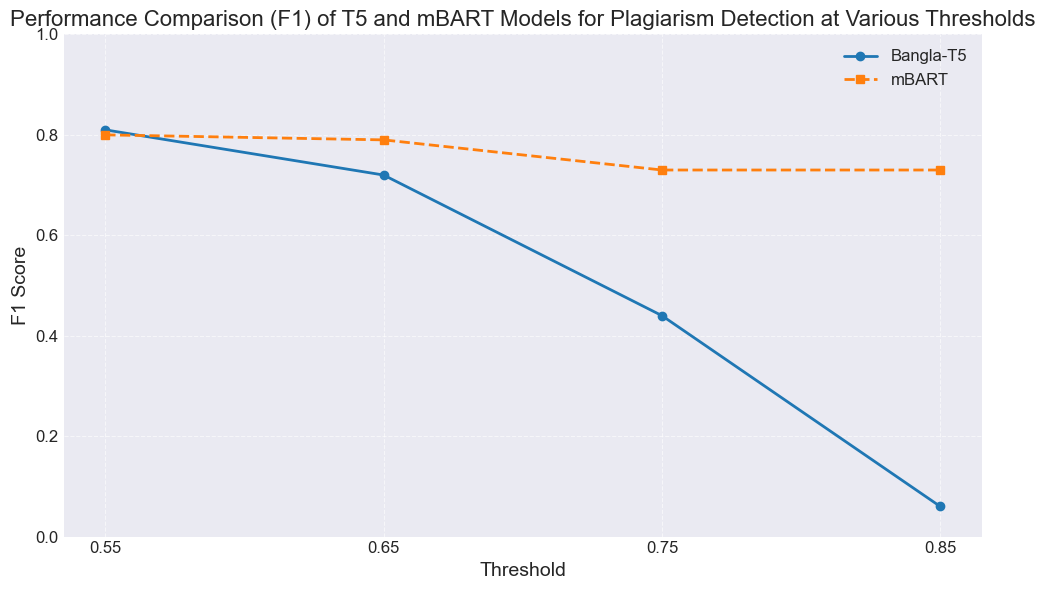

In [21]:
# Re-import libraries after state reset
import matplotlib.pyplot as plt

# Thresholds
thresholds = [0.55, 0.65, 0.75, 0.85]

# F1 scores and BERT scores for T5
t5_f1 = [0.81, 0.72, 0.44, 0.06]
t5_bert = [0.86, 0.86, 0.86, 0.86]

# F1 scores and BERT scores for mBART
mbart_f1 = [0.80, 0.79, 0.73, 0.73]
mbart_bert = [0.75, 0.75, 0.75, 0.75]

# Use an available elegant style
plt.style.use('seaborn-v0_8-darkgrid')

# Define colors
t5_color = '#1f77b4'
mbart_color = '#ff7f0e'

# Plotting F1 scores
plt.figure(figsize=(10, 6))
plt.plot(thresholds, t5_f1, marker='o', linestyle='-', linewidth=2, color=t5_color, label='Bangla-T5')
plt.plot(thresholds, mbart_f1, marker='s', linestyle='--', linewidth=2, color=mbart_color, label='mBART')
plt.title('Performance Comparison (F1) of T5 and mBART Models for Plagiarism Detection at Various Thresholds', fontsize=16)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.xticks(thresholds, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


## Plot 01
This plot shows the F1 Score comparison between Bangla-T5 and mBART for plagiarism detection at different thresholds. As the threshold increases, Bangla-T5 performs worse (lower F1 score), while mBART remains almost constant. This is because Bangla-T5 is more sensitive to higher thresholds, making it less accurate in detecting paraphrases at stricter thresholds.

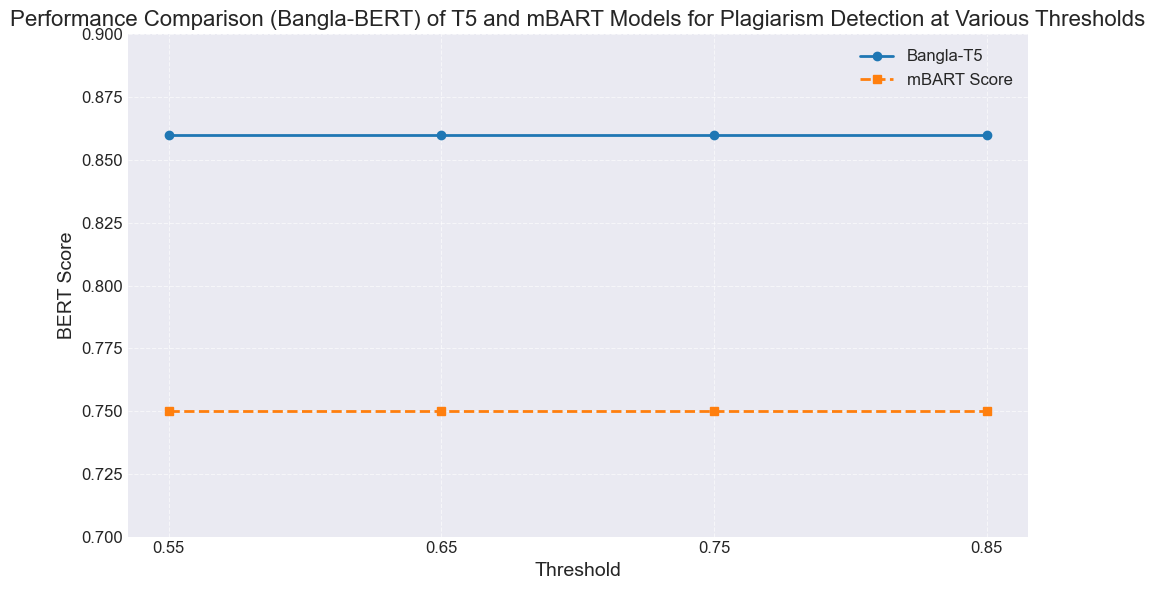

In [ ]:
# Plotting BERT scores
plt.figure(figsize=(10, 6))
plt.plot(thresholds, t5_bert, marker='o', linestyle='-', linewidth=2, color=t5_color, label='Bangla-T5')
plt.plot(thresholds, mbart_bert, marker='s', linestyle='--', linewidth=2, color=mbart_color, label='mBART')
plt.title('Performance Comparison (Bangla-BERT) of T5 and mBART Models for Plagiarism Detection at Various Thresholds', fontsize=16)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('BERT Score', fontsize=14)
plt.xticks(thresholds, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0.7, 0.9)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Plot 02
This plot shows the BERT similarity scores for paraphrases generated by Bangla-T5 and mBART across different thresholds. Bangla-T5 consistently achieves a higher BERT score (~0.86) compared to mBART (~0.75), regardless of the threshold. This means T5’s paraphrases are semantically closer to the original sentence.
However, this does not always lead to better F1 scores, as seen in the earlier F1 plot.
So, while T5 generates better paraphrases (higher BERT score), it performs worse on F1 at strict thresholds due to poor plagiarism classification.


## Conclusion
In conclusion one observation I would like to share is that paraphrase generation did not significantly improve the results in this case. As we know, language models often struggle with low-resource languages like Bangla. However, better performance might be achieved by fine-tuning the language model and experimenting with different types of prompting strategies.